# Numerical Optimization and Large Scale Linear Algebra: 2nd Assignment

Vasileios Dimopoulos

In [1]:
import numpy as np
import scipy.optimize
from scipy.optimize import minimize
import matplotlib.pyplot as plt

Below we create 3 different functions. The first calculates the inverse-squared distance between two given points. The second creates matrix A. Firstly, for each of the 625 pixels, with coordinates x and y ranging from 0 to 25, we find its 3D distance from each of the lamps, using the inverse square functioned already mentioned. With the values calculated, we create a 10x625 matrix d, that has 10 columns, one for each lamp and 625 rows, for each pixel. The value dij has the inverse square 3D distance of pixel j to the lamp i. Then, we want to scale this matrix, so the resulting vector from the dot product of the matrix with a 10-dim ones vector will have a mean of one. We calculate an x value as a scalar we will elementwise multiply matrix d with. The result of the multiplication is matrix A.

In [2]:
def calculate_3d_distance(point1, point2):
    return np.sqrt(np.sum((point2 - point1)**2))

def create_A(lamp_positions):
    d_inv_sq = np.zeros((625,10))
    for i in range(10):
        x = 0
        y = 0
        for j in range(625):
            if (y == 25):
                x += 1
                y = 0
            pixel = np.array([x+0.5,y+0.5,0])
            d_inv_sq[j,i] = (calculate_3d_distance(lamp_positions[i],pixel))**(-2)
            y += 1
            
    p = np.ones(10)  # Replace this with your actual vector p

    elementwise_product = np.multiply(d_inv_sq, p)

    # Calculate x such that the mean is 1
    x = 0.1 / np.mean(elementwise_product)
    
    A = d_inv_sq*x
    
    return A

def calculate_rmse(actual, predicted):
    # Calculate residuals
    residuals = actual - predicted
    
    # Square the residuals
    squared_residuals = residuals ** 2
    
    # Calculate mean of squared residuals
    mean_squared_residuals = np.mean(squared_residuals)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_residuals)
    
    return rmse

Below we can see the functions used to produced the heatmaps and the histograms of the pixel light intensity, when given the predicted l vector. On the heatmap, the positions of the lamps are visible too.

In [3]:
def heatmap(l,lamp_positions,title):
    data = np.empty((25,25))
    x = 0
    y = 0
    for k in range(625):
        if (y == 25):
            x += 1
            y = 0
        data[x,y] = l[k]
        y += 1
    
    heatmap = plt.imshow(data, cmap='inferno')
    plt.title(title)
    plt.gca().invert_yaxis()
    for i in range(10):
        x_coords = lamp_positions[i,0]
        y_coords = lamp_positions[i,1]
        z_coords = lamp_positions[i,2]
        plt.scatter(x_coords, y_coords, color='black', s=5)
        text = f"  {i+1} ({z_coords:.1f})"
        plt.text(x_coords, y_coords, text, color='black', fontsize=8)
    plt.colorbar(heatmap)
    
def plot_histogram(data,title, bins=25, color='lightblue', xlabel='Intensity', ylabel='Number of pixels'):
    plt.hist(data, bins=bins, color=color, edgecolor='blue')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.grid(True)


The function below takes as input the lamp positions and calls previous functions to create the A matrix. Then it predicts the l vector, firstly by setting the p vector to having 1 in every dimension. Then it uses l desired, a 625 dimension ones vector as target and with normal least squares, predicts the lamp powers that will better succeed to produce the desired l (A*p = ldes). Finally, with the same objective, we again use LS but constaint, to only produce positive pi values that will sum up to 10. The function finally calls previous functions to create a heatmap and a histogram of each approach and calculates the Root MSE.

In [4]:
def create_results(lamp_positions, plot = True):
    
    A = create_A(lamp_positions)
    
    p_ones = np.ones(10)
    l_all_ones = np.dot(A,np.ones(10))
    l_des = np.ones(625)
    
    rmse_p_ones = calculate_rmse((l_des),l_all_ones)
    
    
    p_norm_ls = np.dot((np.dot(np.linalg.inv(np.dot(A.T,A)),A.T)),l_des)
    l_pred_norm_ls = np.dot(A, p_norm_ls)
    rmse_p_norm_ls = calculate_rmse(l_des,l_pred_norm_ls)
    
    def objective(p):
        return np.sum((A.dot(p) - l_des)**2)

    def sum_constraint(p):
        return np.sum(p) - 10

    # Constraints object for sum constraint and non-negativity
    constraints = ({'type': 'eq', 'fun': sum_constraint})

    bounds = [(0, None)] * A.shape[1]

    initial_guess = np.ones(A.shape[1])

    # Solve the optimization problem with constraints
    result = minimize(objective, initial_guess, bounds=bounds, constraints=constraints)

    # Extract the optimized parameters
    optimized_p = result.x

    l_pred_constr_ls = np.dot(A, optimized_p)
    rmse_p_constr_ls = calculate_rmse(l_des,l_pred_constr_ls)
    
    if plot:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.sca(axs[0])
        heatmap(l_all_ones,lamp_positions,"Colormap for all lamp power equal to 1")
        plt.sca(axs[1])
        plot_histogram(l_all_ones,"Histogram of the Pixel Light Intensity")
        plt.tight_layout()
        plt.show()
        print(f"RMSE: {rmse_p_ones}")

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.sca(axs[0])
        heatmap(l_pred_norm_ls,lamp_positions,"Colormap for normal LS calculated lamp power")
        plt.sca(axs[1])
        plot_histogram(l_pred_norm_ls,"Histogram of the Pixel Light Intensity")
        plt.tight_layout()
        plt.show()
        print(f"RMSE: {rmse_p_norm_ls}")

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        plt.sca(axs[0])
        heatmap(l_pred_constr_ls,lamp_positions,"Colormap for constraint LS calculated lamp power")
        plt.sca(axs[1])
        plot_histogram(l_pred_constr_ls,"Histogram of the Pixel Light Intensity")
        plt.tight_layout()
        plt.show()
        print(f"RMSE: {rmse_p_constr_ls}")
        print("")
    
    return rmse_p_constr_ls

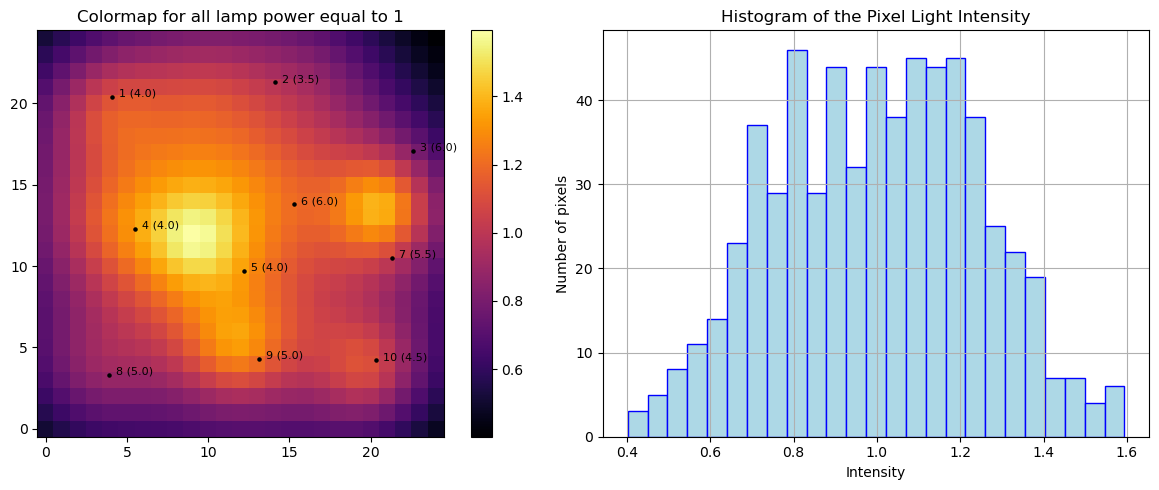

RMSE: 0.24174131853807881


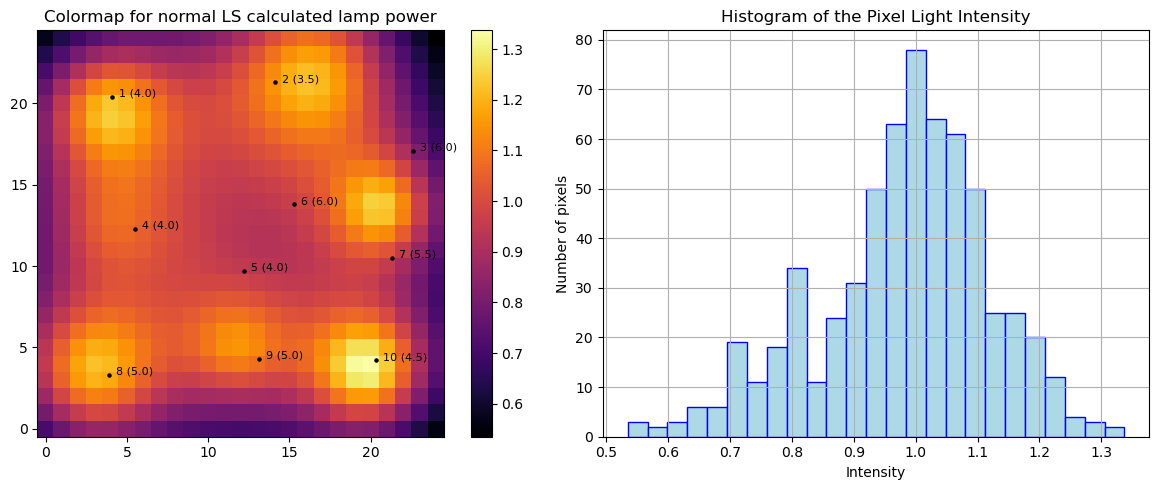

RMSE: 0.14039048134276058


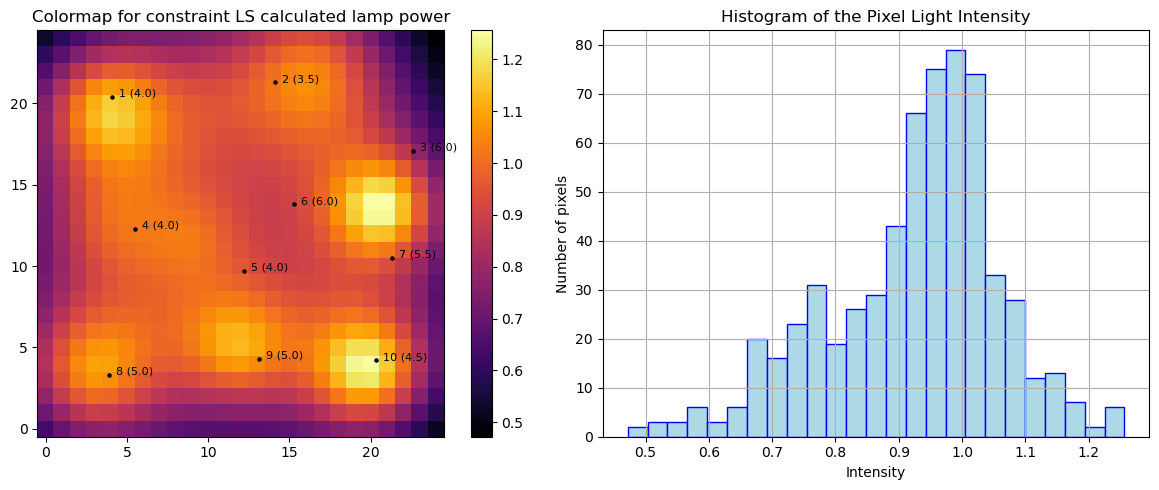

RMSE: 0.15576037336876974



In [5]:
lamp_positions = np.array([
    [4.1, 20.4, 4],
    [14.1, 21.3, 3.5],
    [22.6, 17.1, 6],
    [5.5, 12.3, 4],
    [12.2, 9.7, 4],
    [15.3, 13.8, 6],
    [21.3, 10.5, 5.5],
    [3.9, 3.3, 5],
    [13.1, 4.3, 5],
    [20.3, 4.2, 4.5]
])

rmse = create_results(lamp_positions)

We can see from above, that when all lamps are set to 1, we get the lowest RMSE (0.24). We can expect that as we used the same light levels without making any calculations or thought on the assignment of the lamp power. The histogram shows as that there are a lot of pixels distributed between 0.6 and 1.4 intensity values somewhat uniformly. We would like to see more values get distributed at value 1, which is the desired l for the pixels. The normal LS has the best MSE (0.14). We are now not blindly assigning lamp power but use LS to minimize the loss (pixel intensity distance from desired 1). On the histogram we can see that the distribution becomes more centered and dense for the value of one than the previous approach. Finally, for the constraint LS we have a slightly worse RMSE than normal LS, something to be expected with the use of constraints. Though the metric performance was worse, we can see on the histogram that more values are distributed close to 1 and less on the further numbers. That means that this method managed a more uniform result for the pixels, something that can be seen on the heatmap comparisson.

Below, we will generate random lamp positions, measure the RMSE for the constraint problem and for the first improvement to the original positions, plot the heatmaps and histograms.

In [6]:
def generate_random_lamps(num_lamps):
    lamps = []
    for _ in range(num_lamps):
        # Generate random values for the first and second dimensions (0 to 25)
        dim1 = np.random.uniform(0, 25)
        dim2 = np.random.uniform(0, 25)
        dim3 = np.random.uniform(4, 6)
        
        lamps.append([dim1, dim2, dim3])

    return np.array(lamps)

Trial 1 RMSE: 0.1732238238498717
Trial 2 RMSE: 0.2729077987279371
Trial 3 RMSE: 0.21432132180570262
Trial 4 RMSE: 0.312040610791595
Trial 5 RMSE: 0.22597219846313213
Trial 6 RMSE: 0.2783639820675342
Trial 7 RMSE: 0.1868654745785646
Trial 8 RMSE: 0.17576282227633797
Trial 9 RMSE: 0.29144914786100035
Trial 10 RMSE: 0.35428457094565746
Trial 11 RMSE: 0.21254725036584715
Trial 12 RMSE: 0.2769568877852119
Trial 13 RMSE: 0.3501809449729365
Trial 14 RMSE: 0.21201531822800335
Trial 15 RMSE: 0.15797337212284376
Trial 16 RMSE: 0.20588213890451593
Trial 17 RMSE: 0.22614834870922812
Trial 18 RMSE: 0.20802822262997145
Trial 19 RMSE: 0.17450234757273067
Trial 20 RMSE: 0.23797711250034487
Trial 21 RMSE: 0.14058452396159785
Better Lamp Positions Found


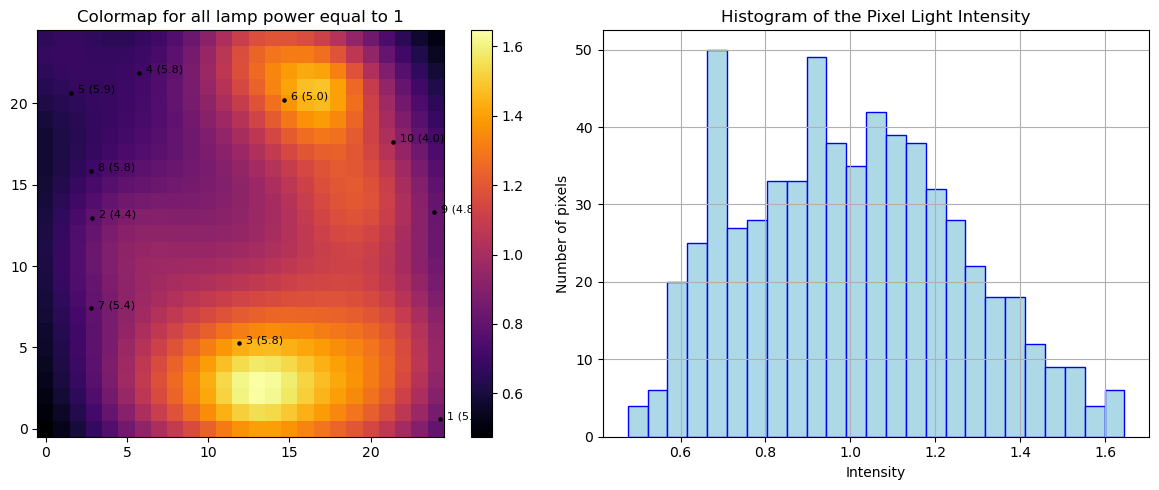

RMSE: 0.254977050457582


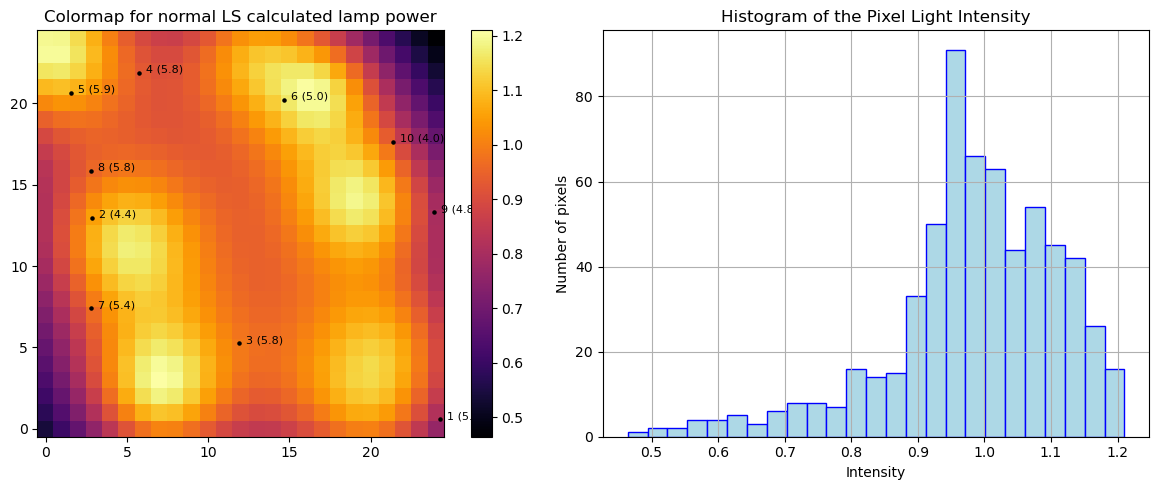

RMSE: 0.1313748933314155


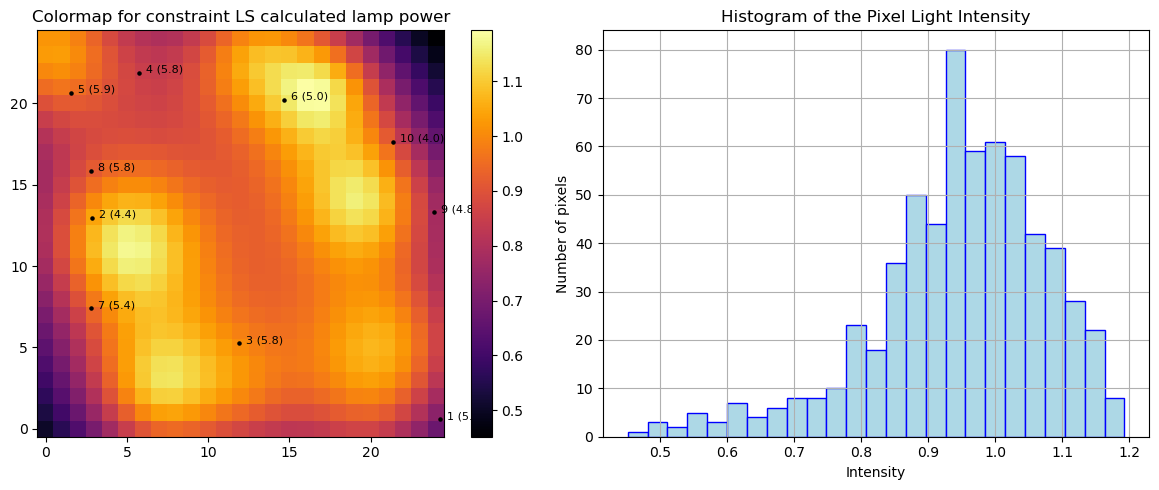

RMSE: 0.14058452396159785



In [7]:
best_rmse = rmse
i = 1
while True:
    random_lamps = generate_random_lamps(10)
    rmse = create_results(random_lamps, plot = False)
    print(f"Trial {i} RMSE: {rmse}")
    if (rmse < best_rmse):
        print("Better Lamp Positions Found")
        rmse = create_results(random_lamps)
        break
    else:
          i += 1

On the 21st trial we found the lamp positions seen above that improve RMSE to 0.14 for the constraint problem. On the heatmap, it is clear that the lighting intensity levels are more uniform for most pixels that the previous positions. The histogram shows distribution closer to 1 for most of our values. 